In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pickle
import os

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [2]:
from IPython.display import display as print
from core_lib import plot_dataset,r2_loss,get_predict_ks, get_dcdt_func_for_sunode
from core_lib import get_predict_starts
from core_lib import get_model, get_model2, distance_func, MY_EPSILON
from core_lib import MyDataset


import core_lib
import importlib
importlib.reload(core_lib);

In [3]:
db_csv_path = "dataset/data.csv"

# 忽略部分数据的结果，但是忽略的数据正常
# idata_save_path = "runtime/pts/research-fake-data-success.dt"

# 忽略部分数据的结果，但是忽略的数据不正常
idata_save_path = "runtime/pts/research-fake-data-randome-fake-success-v2.dt"

# dataset_ori = core_lib.MyDataset(db_csv_path)
# df_ori = dataset_ori.get_df()
# cct_names, error_names = dataset_ori.get_var_col_names()
# c0 = df_ori[cct_names].iloc[0].values


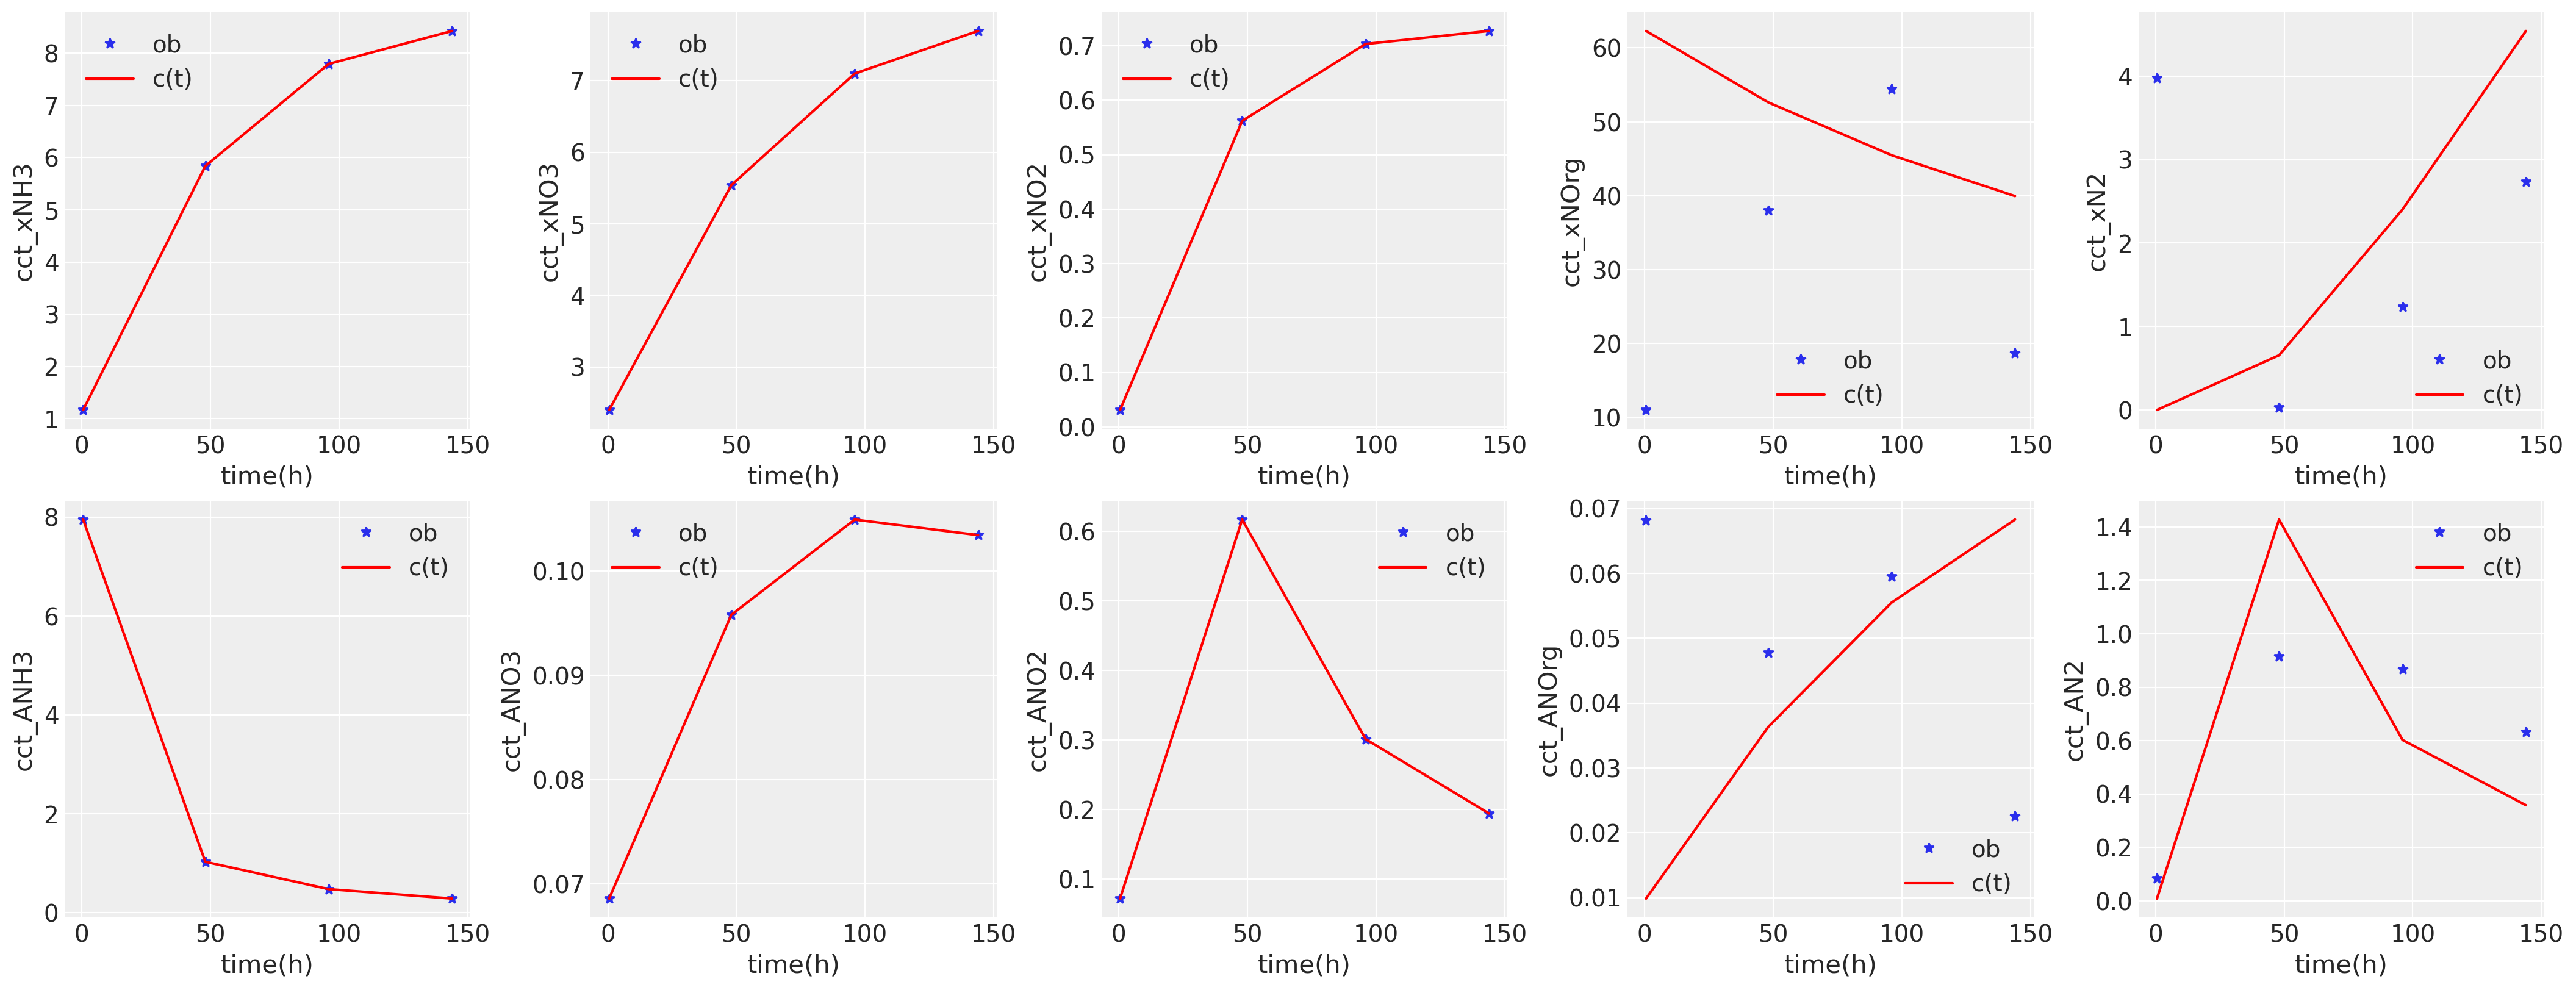

In [4]:
# 假设都是一级动力学
k_kinetics = np.repeat(1, 11).astype(np.uint8)
# k_kinetics = np.array([0,0,0,0,1,1,0,0,1,1,0]).astype(np.uint8)
ks = np.array([0.00071942, 0.00269696, 0.00498945, 0.00444931, 0.00571299, 0.00801272, 0.00131931, 0.00319959, 0.00415571, 0.00228432, 0.00177611])
#  =======================================================
import copy

# t_eval = np.linspace(0, 150, 100)
t_eval = np.array([0.5, 48, 96, 144])

# 初始化原始数据
dataset_ori = core_lib.MyDataset(db_csv_path)

# 初始化正确的模拟数据
dataset_sim = core_lib.MyDataset(db_csv_path)
_cct_names = dataset_sim.get_cct_names()
_c0 = dataset_sim.df[_cct_names].iloc[0].values
dataset_sim.set_as_sim_dataset(t_eval, _c0, t0=0.5, args=(ks, k_kinetics))

# 由模拟数据，生成fake字段
dataset_fake = copy.deepcopy(dataset_sim)
fake_colums = dataset_fake.get_fake_cct_names()
dataset_fake.set_random(c_names=fake_colums)


dataset = dataset_fake
df = dataset.get_df()
cct_names, error_names = dataset.get_var_col_names()
c0 = df[cct_names].iloc[0].values
plot_dataset(dataset, dataset_sim)

In [5]:
print(1e-05 + 0.1)


0.10001

In [6]:

mcmc_model = core_lib.get_model(dataset_sim, t_eval, k_kinetics, distance=core_lib.distance_func_v2, epsilon=core_lib.MY_EPSILON_TEE, k_sigma_priors=0.01, kf_type=0, c0_type=0)



[1.16666667e+00 2.39880952e+00 3.11000000e-02 6.22850000e+01
 7.11000000e-05 7.94863498e+00 6.85792330e-02 7.23100000e-02
 9.85666700e-03 8.32000000e-03]


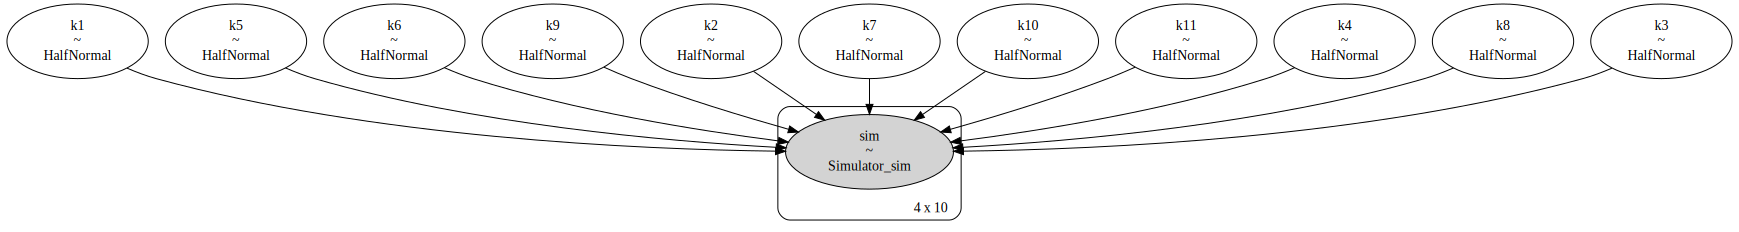

In [7]:
# print(get_format_time(),idata_save_path)
# print(ks, c0)
pm.model_to_graphviz(mcmc_model)

In [9]:
print(idata_save_path)
# idata_lv = pickle.load(open(idata_save_path, 'rb'))

os.makedirs(os.path.dirname(idata_save_path), exist_ok=True)
idata_lv = pm.sample_smc(draws=2000, chains=4, model=mcmc_model, progressbar=True)
# pickle.dump(idata_lv,open(idata_save_path, 'wb'))

'runtime/pts/research-fake-data-randome-fake-success-v2.dt'

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


KeyboardInterrupt: 

In [13]:
# az.plot_trace(idata_lv, kind="rank_vlines");
df[cct_names]

,xNH3,xNO3,xNO2,xNOrg,xN2,ANH3,ANO3,ANO2,ANOrg,AN2
0,1.166667,2.398810,0.031100,11.719043,2.159090,7.948635,0.068579,0.072310,0.002826,0.936046
1,5.837087,5.539301,0.562177,20.638291,2.389418,1.032210,0.095807,0.616771,0.016151,0.087855
2,7.792909,7.098859,0.703303,32.601827,3.571571,0.478821,0.104952,0.301327,0.026450,0.077087
3,8.424422,7.693928,0.727245,26.941536,0.952834,0.288168,0.103458,0.194543,0.043289,0.004717


In [14]:
print(az.summary(idata_lv, round_to=10))
print(ks)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k1,0.012355,0.007542,0.000680,0.025489,0.000434,0.000307,197.843069,2037.598687,1.018198
k2,0.001099,0.000323,0.000511,0.001682,0.000007,0.000005,1908.887987,3594.051670,1.005348
k3,0.012811,0.007285,0.001415,0.025917,0.000201,0.000153,1264.156835,551.254788,1.004214
k4,0.004685,0.000656,0.003487,0.005946,0.000016,0.000011,1799.752911,3601.116763,1.008971
k5,0.002660,0.001781,0.000330,0.005964,0.000027,0.000019,2595.805072,4313.017158,1.006999
k6,0.005202,0.001417,0.002204,0.007457,0.000037,0.000026,1507.193692,528.958042,1.008494
k7,0.003359,0.001971,0.000320,0.006881,0.000083,0.000058,235.883047,900.194000,1.019902
k8,0.001353,0.001105,0.000069,0.003343,0.000019,0.000014,2570.832535,2100.443475,1.006782
k9,0.007471,0.002299,0.003307,0.011949,0.000037,0.000027,3618.412903,3690.054690,1.004123
k10,0.017060,0.003782,0.010539,0.024353,0.000075,0.000056,2613.660579,908.009183,1.002365


array([0.00071942, 0.00269696, 0.00498945, 0.00444931, 0.00571299,
       0.00801272, 0.00131931, 0.00319959, 0.00415571, 0.00228432,
       0.00177611])

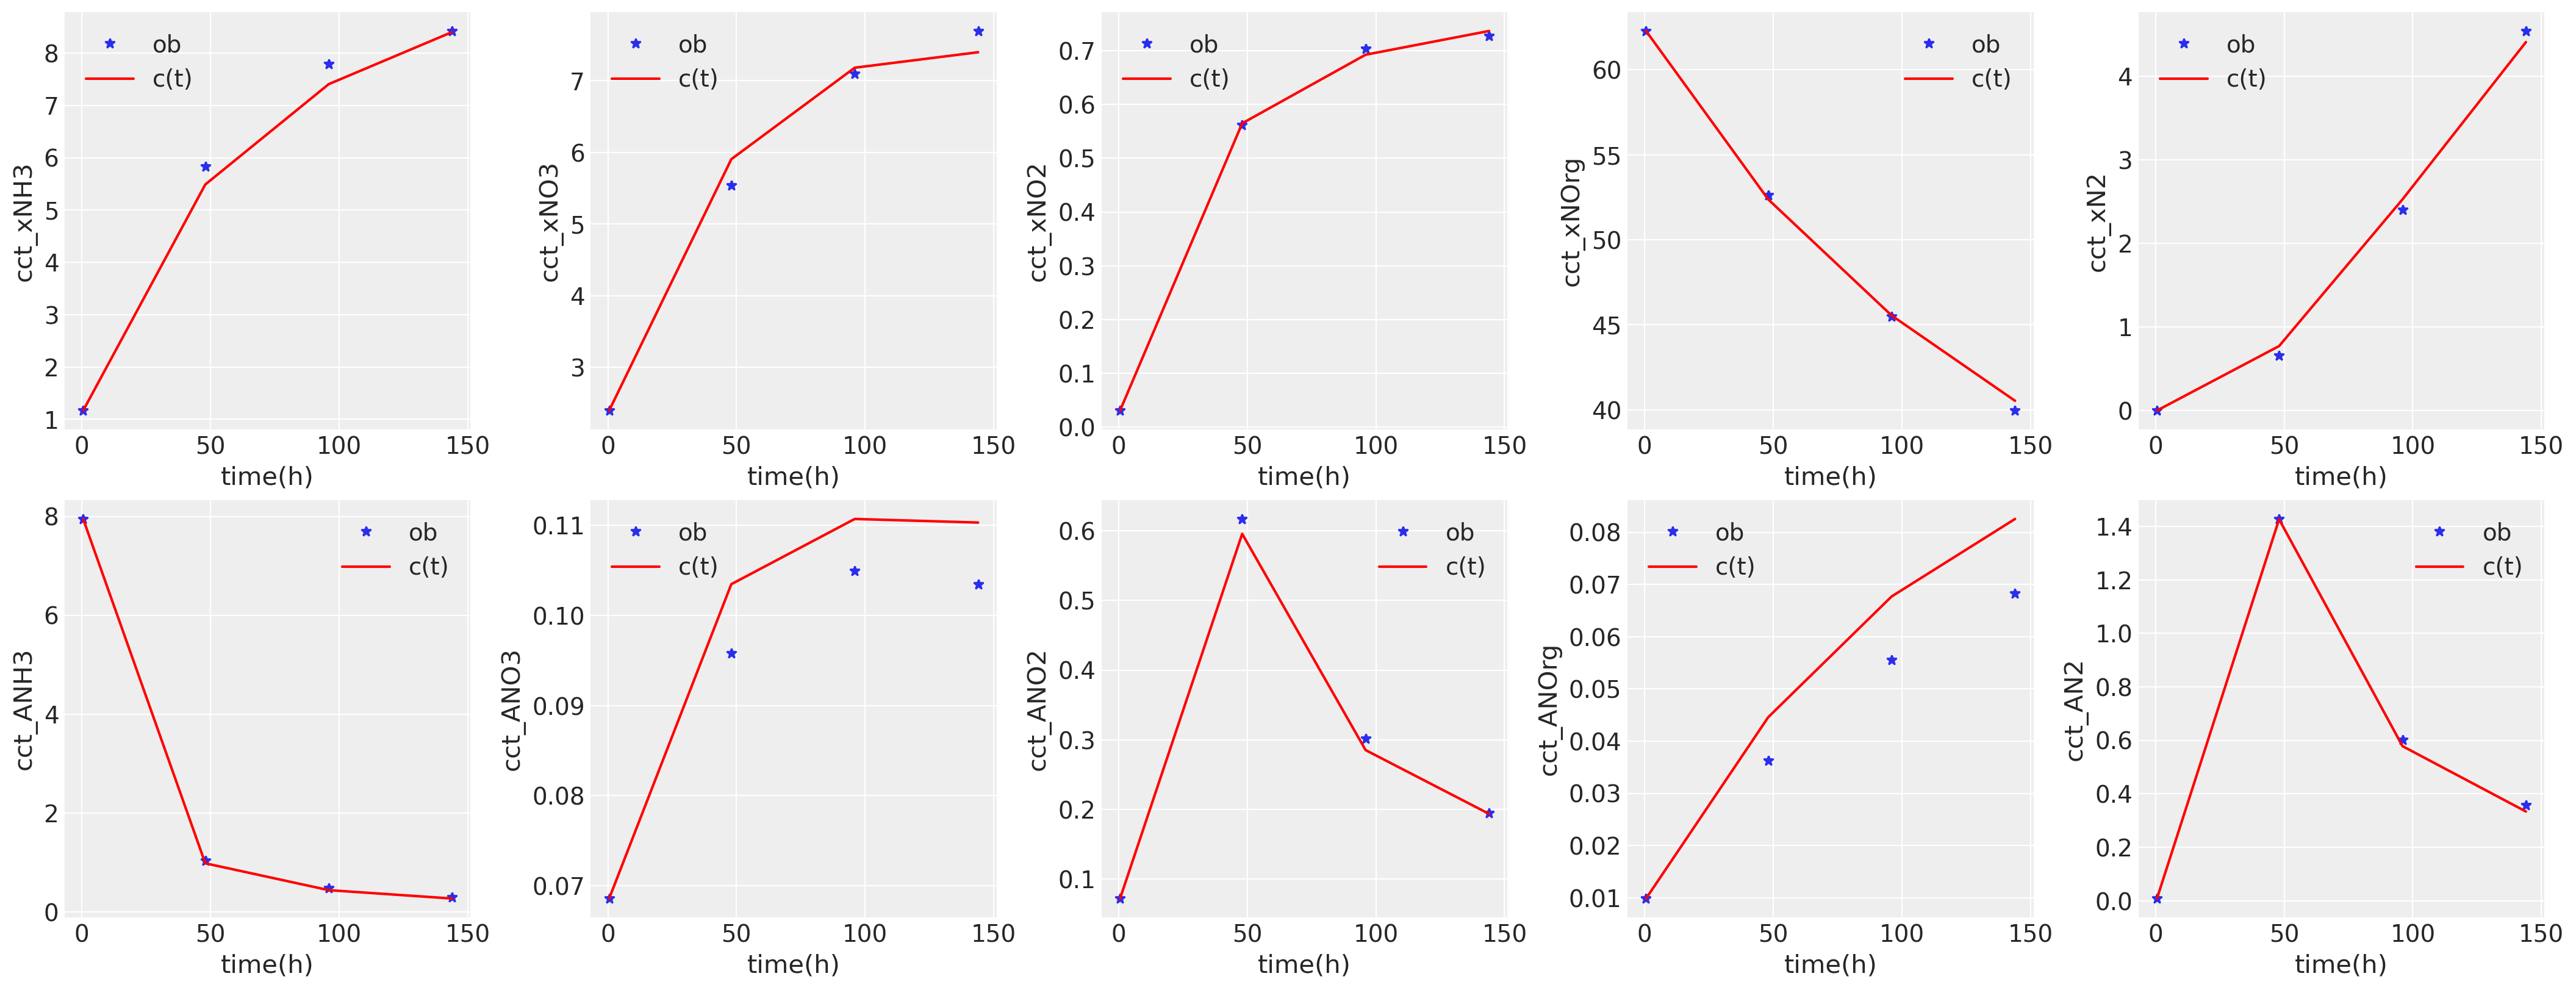

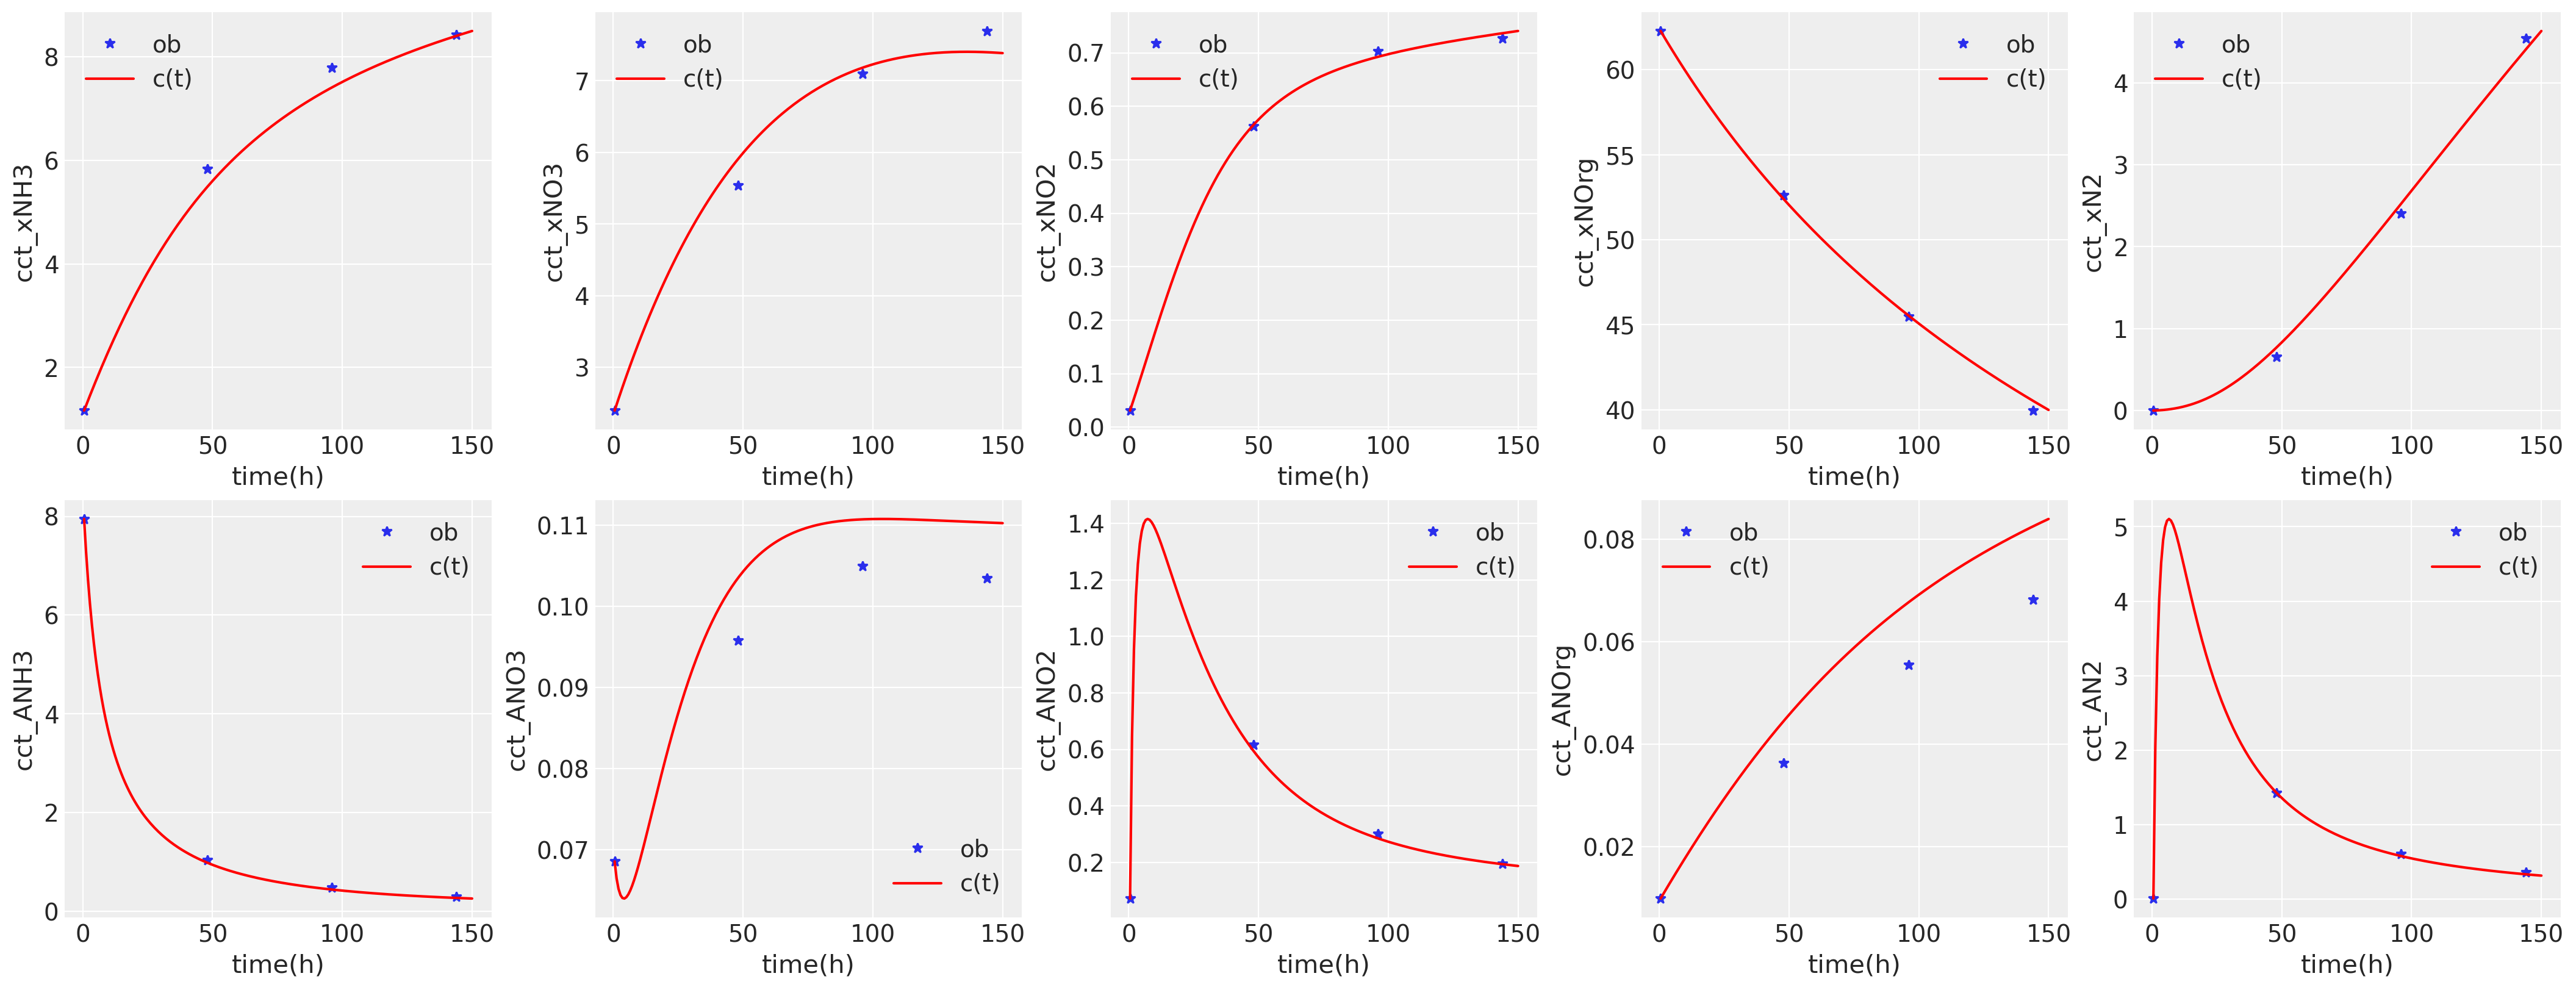

array([0.00322734, 0.00356824, 0.00960109, 0.0049472 , 0.00906227,
       0.00834164, 0.00320276, 0.00564261, 0.00570284, 0.00215351,
       0.00230498])

In [9]:
ks_predict = get_predict_ks(idata_lv)
k_kinetics = np.repeat(1, 11).astype(np.uint8)
t_eval = np.array([0.5, 48, 96, 144])

dataset_new = MyDataset(db_csv_path)
cct_names, error_names = dataset_new.get_var_col_names()
gt_s = dataset_new.get_cct()[0]

dataset_new.set_as_sim_dataset(t_eval, gt_s, t0=0.5, args=(ks_predict, k_kinetics))
plot_dataset(dataset_sim, dataset_new)
# print("r2_loss", r2_loss(dataset_new.get_cct(), dataset.get_cct()))


t_eval_new = np.linspace(0.5, 150, 200)
dataset_new2 = MyDataset(db_csv_path)
dataset_new2.set_as_sim_dataset(t_eval_new, gt_s, t0=0.5, args=(ks_predict, k_kinetics))
plot_dataset(dataset_sim, dataset_new2)

print(ks_predict)

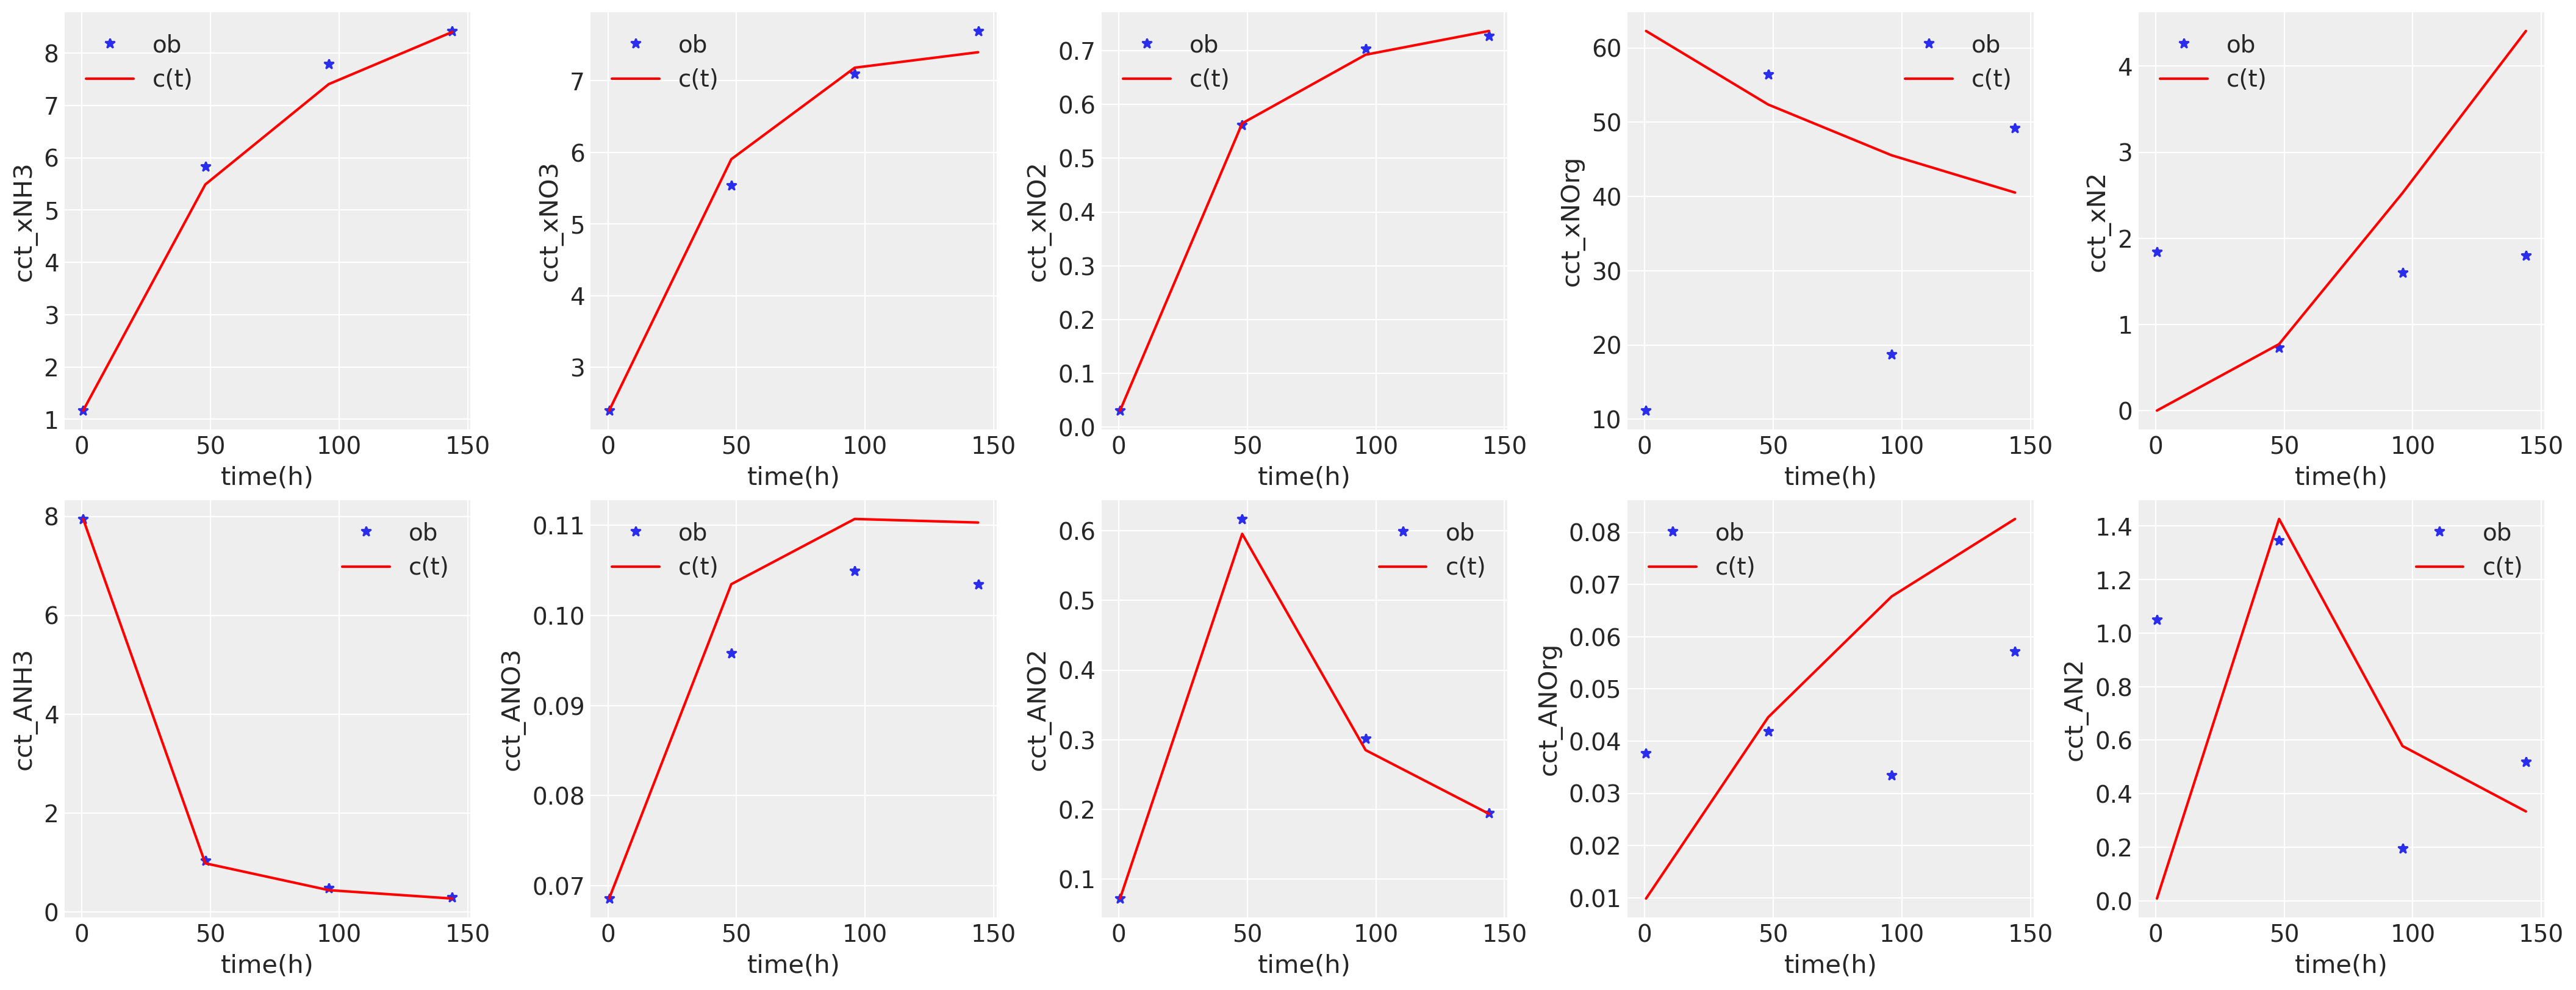

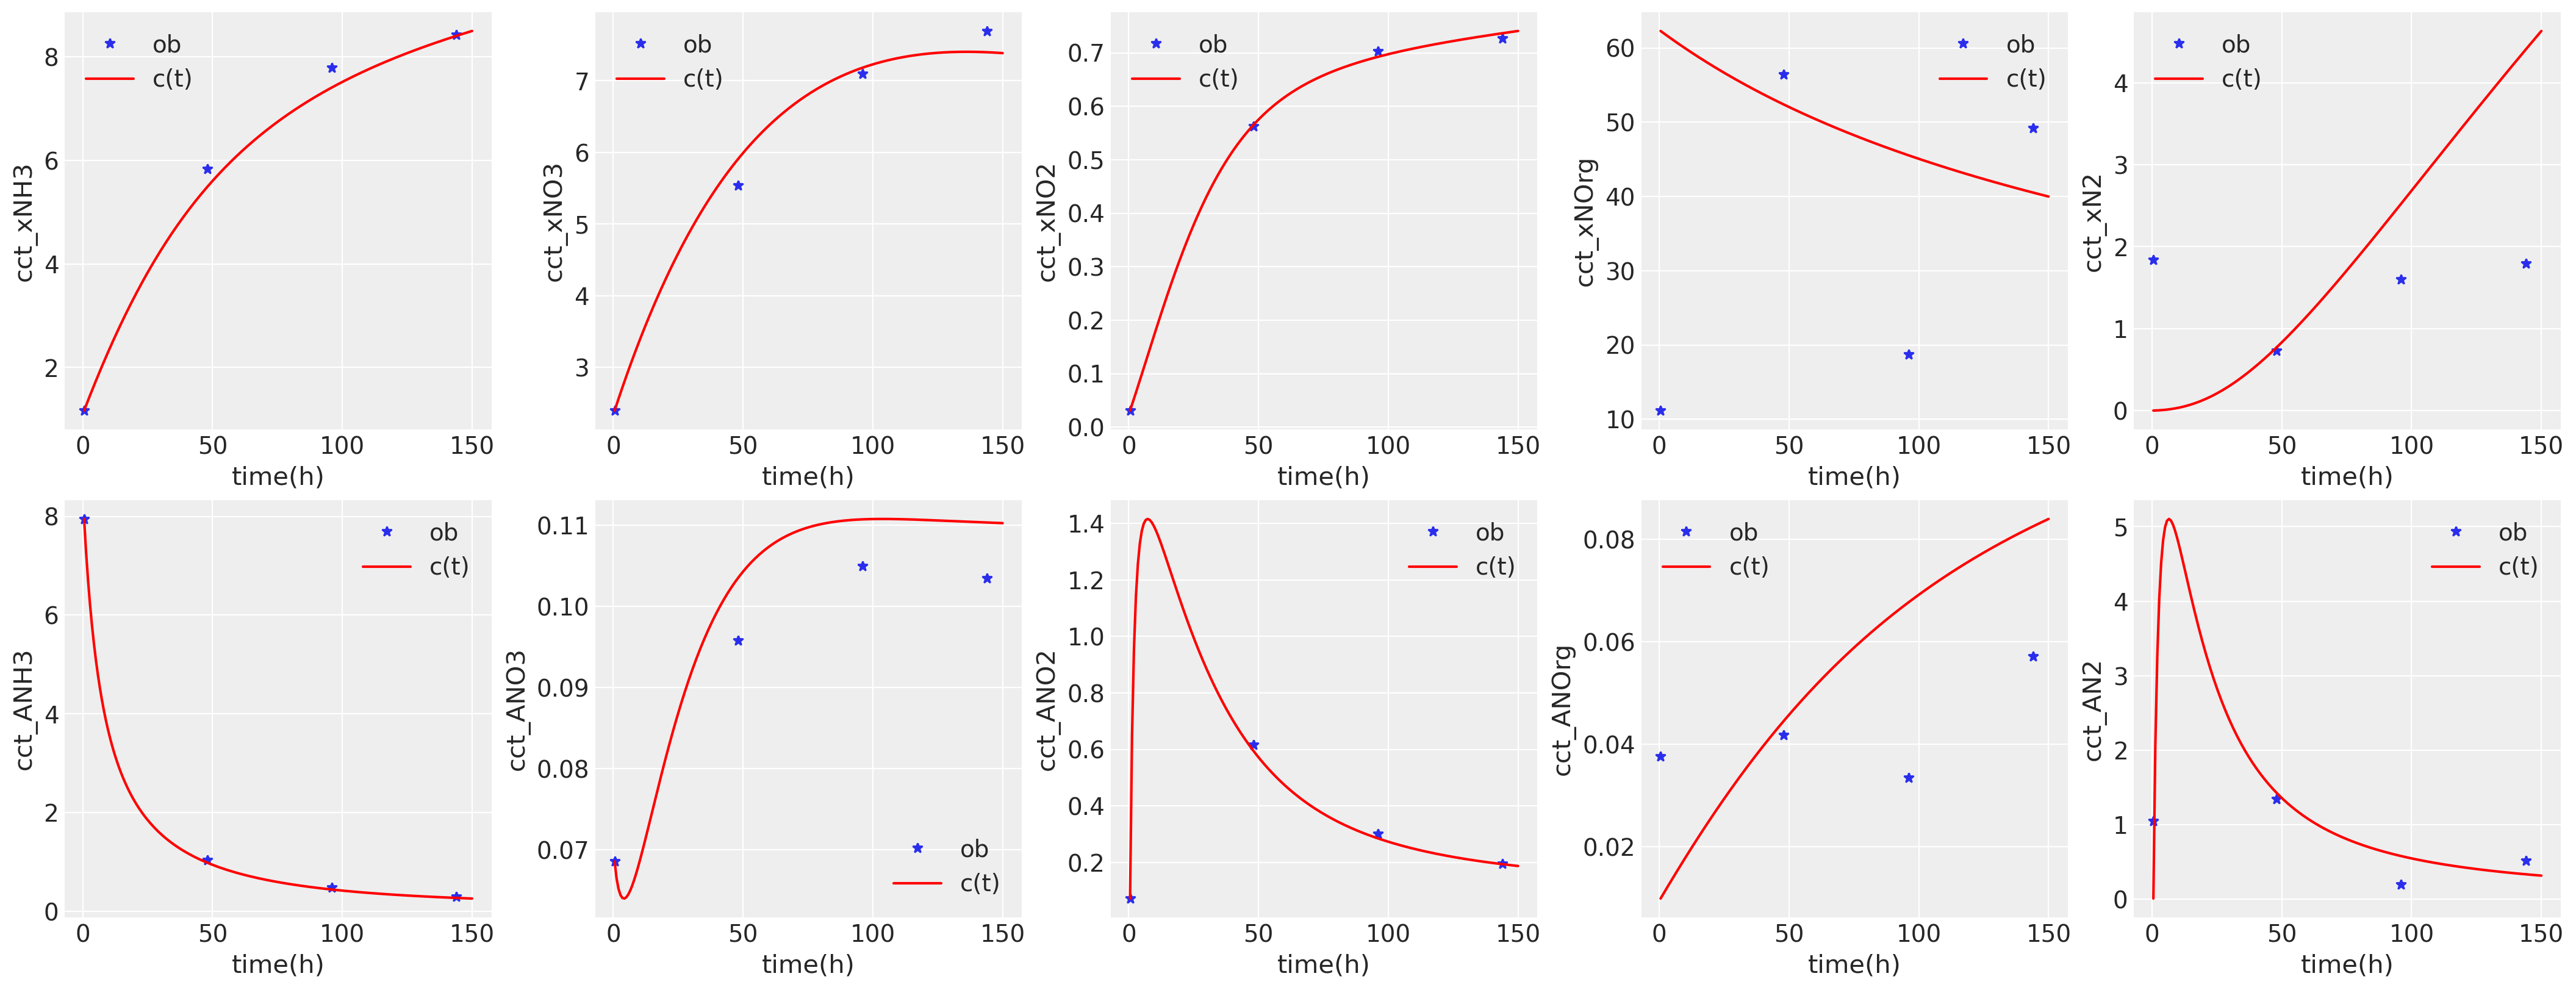

In [10]:
plot_dataset(dataset_fake, dataset_new)
plot_dataset(dataset_fake, dataset_new2)

In [13]:
ks_predict

array([0.00296455, 0.00351043, 0.00889154, 0.00493207, 0.00863788,
       0.00848131, 0.00356168, 0.00536778, 0.00551921, 0.00211468,
       0.00231901])

In [ ]:
# [0.00071942, 0.00269696, 0.00498945, 0.00444931, 0.00571299,
    #    0.00801272, 0.00131931, 0.00319959, 0.00415571, 0.00228432,
    #    0.00177611]